# CEC2017 Optimization Project

This notebook contains the complete implementation of the CEC2017 optimization project. It includes:
1.  **Algorithms**: Harmony Search (HS), Adaptive HS, Hybrid HS, PSO, GA, Greedy, GSA, and ABC.
2.  **Experiment**: A script to run these algorithms on the CEC2017 benchmark functions.
3.  **Analysis**: Tools to generate summary tables and convergence plots.

## 1. Setup
First, we import necessary libraries and setup the environment.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor

# Add the cec2017-py directory to sys.path
# Assuming the notebook is in the root of the project directory
if os.path.exists('cec2017-py'):
    sys.path.append(os.path.abspath('cec2017-py'))
else:
    print("Warning: cec2017-py directory not found. Please ensure it exists.")

try:
    import cec2017.functions as functions
    print("CEC2017 library loaded successfully.")
except ImportError:
    print("Error: Could not import cec2017 library.")

CEC2017 library loaded successfully.


## 2. Algorithms

### 2.1 Base Algorithm Class
A base class to handle common functionality like evaluation counting and history tracking.

In [2]:
class Algorithm:
    def __init__(self, func, dim, max_evals=30000, lb=-100, ub=100):
        self.func = func
        self.dim = dim
        self.max_evals = max_evals
        self.lb = lb
        self.ub = ub
        self.eval_count = 0
        self.best_fitness_history = []
        self.best_solution = None
        self.best_fitness = float('inf')

    def evaluate(self, solution):
        if self.eval_count >= self.max_evals:
            return float('inf')
        
        fitness = self.func([solution])[0]
        self.eval_count += 1
        
        if fitness < self.best_fitness:
            self.best_fitness = fitness
            self.best_solution = solution.copy()
            
        self.best_fitness_history.append(self.best_fitness)
        return fitness

### 2.2 Harmony Search (HS) and Variants
Implementation of Classical HS, Adaptive HS, and Hybrid HS.

In [3]:
class HarmonySearch:
    def __init__(self, func, dim, max_evals=30000, hms=50, hmcr=0.9, par=0.3, bw=0.01, lb=-100, ub=100):
        self.func = func
        self.dim = dim
        self.max_evals = max_evals
        self.hms = hms  # Harmony Memory Size
        self.hmcr = hmcr  # Harmony Memory Consideration Rate
        self.par = par  # Pitch Adjusting Rate
        self.bw = bw  # Bandwidth
        self.lb = lb
        self.ub = ub
        
        self.HM = None
        self.fitness = None
        self.eval_count = 0
        self.best_fitness_history = []
        self.best_solution = None
        self.best_fitness = float('inf')

    def initialize(self):
        self.HM = np.random.uniform(self.lb, self.ub, (self.hms, self.dim))
        self.fitness = np.zeros(self.hms)
        for i in range(self.hms):
            if self.eval_count < self.max_evals:
                self.fitness[i] = self.func([self.HM[i]])[0]
                self.eval_count += 1
            else:
                self.fitness[i] = float('inf')
        
        self._update_best()

    def _update_best(self):
        best_idx = np.argmin(self.fitness)
        if self.fitness[best_idx] < self.best_fitness:
            self.best_fitness = self.fitness[best_idx]
            self.best_solution = self.HM[best_idx].copy()
        
    def improvise(self):
        new_harmony = np.zeros(self.dim)
        for i in range(self.dim):
            if np.random.rand() < self.hmcr:
                # Memory consideration
                index = np.random.randint(0, self.hms)
                new_harmony[i] = self.HM[index, i]
                
                # Pitch adjustment
                if np.random.rand() < self.par:
                    new_harmony[i] += np.random.uniform(-1, 1) * self.bw
                    # Boundary check
                    new_harmony[i] = np.clip(new_harmony[i], self.lb, self.ub)
            else:
                # Random selection
                new_harmony[i] = np.random.uniform(self.lb, self.ub)
        
        return new_harmony

    def update_hm(self, new_harmony, new_fitness):
        worst_idx = np.argmax(self.fitness)
        if new_fitness < self.fitness[worst_idx]:
            self.HM[worst_idx] = new_harmony
            self.fitness[worst_idx] = new_fitness
            self._update_best()

    def run(self):
        self.initialize()
        
        while self.eval_count < self.max_evals:
            new_harmony = self.improvise()
            
            # Evaluate new harmony
            new_fitness = self.func([new_harmony])[0]
            self.eval_count += 1
            
            self.update_hm(new_harmony, new_fitness)
            self.best_fitness_history.append(self.best_fitness)
            
        return self.best_fitness, self.best_solution, self.best_fitness_history

class AdaptiveHS(HarmonySearch):
    def __init__(self, func, dim, max_evals=30000, hms=50, 
                 hmcr_min=0.9, hmcr_max=0.99, 
                 par_min=0.3, par_max=0.99, 
                 bw_min=0.0001, bw_max=0.5, 
                 lb=-100, ub=100):
        super().__init__(func, dim, max_evals, hms, hmcr_max, par_min, bw_max, lb, ub)
        self.hmcr_min = hmcr_min
        self.hmcr_max = hmcr_max
        self.par_min = par_min
        self.par_max = par_max
        self.bw_min = bw_min
        self.bw_max = bw_max

    def run(self):
        self.initialize()
        
        while self.eval_count < self.max_evals:
            # Dynamic parameter adjustment
            progress = self.eval_count / self.max_evals
            self.par = self.par_min + (self.par_max - self.par_min) * progress
            self.bw = self.bw_max * np.exp(np.log(self.bw_min / self.bw_max) * progress)
            
            new_harmony = self.improvise()
            
            new_fitness = self.func([new_harmony])[0]
            self.eval_count += 1
            
            self.update_hm(new_harmony, new_fitness)
            self.best_fitness_history.append(self.best_fitness)
            
        return self.best_fitness, self.best_solution, self.best_fitness_history

class HybridHS(HarmonySearch):
    def __init__(self, func, dim, max_evals=30000, hms=50, hmcr=0.9, par=0.3, bw=0.01, lb=-100, ub=100, local_search_rate=0.01):
        super().__init__(func, dim, max_evals, hms, hmcr, par, bw, lb, ub)
        self.local_search_rate = local_search_rate

    def local_search(self, solution):
        # Simple local search (e.g., small random perturbation)
        new_solution = solution + np.random.uniform(-self.bw, self.bw, self.dim)
        new_solution = np.clip(new_solution, self.lb, self.ub)
        return new_solution

    def run(self):
        self.initialize()
        
        while self.eval_count < self.max_evals:
            new_harmony = self.improvise()
            
            # Apply local search with some probability
            if np.random.rand() < self.local_search_rate:
                new_harmony = self.local_search(new_harmony)

            new_fitness = self.func([new_harmony])[0]
            self.eval_count += 1
            
            self.update_hm(new_harmony, new_fitness)
            self.best_fitness_history.append(self.best_fitness)
            
        return self.best_fitness, self.best_solution, self.best_fitness_history

### 2.3 Other Algorithms
Implementation of PSO, GA, Greedy, GSA, and ABC.

In [4]:
class PSO(Algorithm):
    def __init__(self, func, dim, max_evals=30000, pop_size=30, w=0.729, c1=1.49445, c2=1.49445, lb=-100, ub=100):
        super().__init__(func, dim, max_evals, lb, ub)
        self.pop_size = pop_size
        self.w = w
        self.c1 = c1
        self.c2 = c2

    def run(self):
        # Initialization
        X = np.random.uniform(self.lb, self.ub, (self.pop_size, self.dim))
        V = np.zeros((self.pop_size, self.dim))
        P = X.copy()
        P_fitness = np.array([self.evaluate(x) for x in X])
        
        # Global best is already updated in evaluate() via self.best_fitness
        # But we need the index for the loop
        g_best = self.best_solution.copy()
        
        while self.eval_count < self.max_evals:
            r1 = np.random.rand(self.pop_size, self.dim)
            r2 = np.random.rand(self.pop_size, self.dim)
            
            V = self.w * V + self.c1 * r1 * (P - X) + self.c2 * r2 * (g_best - X)
            X = X + V
            X = np.clip(X, self.lb, self.ub)
            
            for i in range(self.pop_size):
                if self.eval_count >= self.max_evals:
                    break
                
                fitness = self.evaluate(X[i])
                
                if fitness < P_fitness[i]:
                    P[i] = X[i].copy()
                    P_fitness[i] = fitness
                    
            g_best = self.best_solution.copy()
            
        return self.best_fitness, self.best_solution, self.best_fitness_history

class GA(Algorithm):
    def __init__(self, func, dim, max_evals=30000, pop_size=50, mutation_rate=0.05, crossover_rate=0.8, lb=-100, ub=100):
        super().__init__(func, dim, max_evals, lb, ub)
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate

    def run(self):
        # Initialization
        population = np.random.uniform(self.lb, self.ub, (self.pop_size, self.dim))
        fitnesses = np.array([self.evaluate(ind) for ind in population])
        
        while self.eval_count < self.max_evals:
            new_population = []
            
            # Elitism: keep the best
            best_idx = np.argmin(fitnesses)
            new_population.append(population[best_idx].copy())
            
            while len(new_population) < self.pop_size:
                if self.eval_count >= self.max_evals:
                    break

                # Selection (Tournament)
                idx1, idx2 = np.random.randint(0, self.pop_size, 2)
                parent1 = population[idx1] if fitnesses[idx1] < fitnesses[idx2] else population[idx2]
                
                idx3, idx4 = np.random.randint(0, self.pop_size, 2)
                parent2 = population[idx3] if fitnesses[idx3] < fitnesses[idx4] else population[idx4]
                
                # Crossover
                if np.random.rand() < self.crossover_rate:
                    point = np.random.randint(1, self.dim)
                    child = np.concatenate((parent1[:point], parent2[point:]))
                else:
                    child = parent1.copy()
                
                # Mutation
                if np.random.rand() < self.mutation_rate:
                    mutation_point = np.random.randint(0, self.dim)
                    child[mutation_point] += np.random.uniform(-1, 1)
                    child[mutation_point] = np.clip(child[mutation_point], self.lb, self.ub)
                
                new_population.append(child)
            
            population = np.array(new_population)[:self.pop_size]
            # Evaluate new population
            for i in range(len(population)):
                 if self.eval_count < self.max_evals:
                    fitnesses[i] = self.evaluate(population[i])
            
        return self.best_fitness, self.best_solution, self.best_fitness_history

class Greedy(Algorithm):
    def __init__(self, func, dim, max_evals=30000, lb=-100, ub=100):
        super().__init__(func, dim, max_evals, lb, ub)

    def run(self):
        # Simple Random Search / Greedy
        # Generate random solution, if better keep it
        
        current_solution = np.random.uniform(self.lb, self.ub, self.dim)
        current_fitness = self.evaluate(current_solution)
        
        while self.eval_count < self.max_evals:
            new_solution = np.random.uniform(self.lb, self.ub, self.dim)
            new_fitness = self.evaluate(new_solution)
            
            if new_fitness < current_fitness:
                current_solution = new_solution
                current_fitness = new_fitness
                
        return self.best_fitness, self.best_solution, self.best_fitness_history

class GSA(Algorithm):
    def __init__(self, func, dim, max_evals=30000, pop_size=50, G0=100, alpha=20, lb=-100, ub=100):
        super().__init__(func, dim, max_evals, lb, ub)
        self.pop_size = pop_size
        self.G0 = G0
        self.alpha = alpha

    def run(self):
        X = np.random.uniform(self.lb, self.ub, (self.pop_size, self.dim))
        V = np.zeros((self.pop_size, self.dim))
        fitness = np.array([self.evaluate(x) for x in X])
        
        while self.eval_count < self.max_evals:
            iteration = self.eval_count / self.pop_size
            max_iter = self.max_evals / self.pop_size
            
            G = self.G0 * np.exp(-self.alpha * iteration / max_iter)
            
            best = np.min(fitness)
            worst = np.max(fitness)
            
            epsilon = 1e-10
            M = (fitness - worst) / (best - worst + epsilon)
            M = M / np.sum(M)
            
            F = np.zeros((self.pop_size, self.dim))
            for i in range(self.pop_size):
                for j in range(self.pop_size):
                    if i != j:
                        R = np.linalg.norm(X[i] - X[j])
                        force = G * (M[i] * M[j]) / (R + epsilon) * (X[j] - X[i])
                        F[i] += np.random.rand() * force
            
            a = F / (M[:, None] + epsilon)
            V = np.random.rand(self.pop_size, self.dim) * V + a
            X = X + V
            X = np.clip(X, self.lb, self.ub)
            
            for i in range(self.pop_size):
                if self.eval_count < self.max_evals:
                    fitness[i] = self.evaluate(X[i])
                    
        return self.best_fitness, self.best_solution, self.best_fitness_history

class ABC(Algorithm):
    def __init__(self, func, dim, max_evals=30000, pop_size=50, limit=100, lb=-100, ub=100):
        super().__init__(func, dim, max_evals, lb, ub)
        self.pop_size = pop_size # Colony size
        self.n_food = pop_size // 2
        self.limit = limit

    def run(self):
        # Initialization
        foods = np.random.uniform(self.lb, self.ub, (self.n_food, self.dim))
        fitness = np.array([self.evaluate(x) for x in foods])
        trial = np.zeros(self.n_food)
        
        while self.eval_count < self.max_evals:
            # Employed Bees
            for i in range(self.n_food):
                if self.eval_count >= self.max_evals: break
                
                k = np.random.randint(0, self.n_food)
                while k == i: k = np.random.randint(0, self.n_food)
                
                phi = np.random.uniform(-1, 1, self.dim)
                new_solution = foods[i] + phi * (foods[i] - foods[k])
                new_solution = np.clip(new_solution, self.lb, self.ub)
                
                new_fitness = self.evaluate(new_solution)
                
                if new_fitness < fitness[i]:
                    foods[i] = new_solution
                    fitness[i] = new_fitness
                    trial[i] = 0
                else:
                    trial[i] += 1
            
            # Onlooker Bees
            if np.max(fitness) != np.min(fitness):
                 probs = (np.max(fitness) - fitness) / (np.max(fitness) - np.min(fitness) + 1e-10)
            else:
                 probs = np.ones(self.n_food)
            probs = probs / np.sum(probs)
            
            for i in range(self.n_food):
                if self.eval_count >= self.max_evals: break
                
                selected = np.random.choice(self.n_food, p=probs)
                
                k = np.random.randint(0, self.n_food)
                while k == selected: k = np.random.randint(0, self.n_food)
                
                phi = np.random.uniform(-1, 1, self.dim)
                new_solution = foods[selected] + phi * (foods[selected] - foods[k])
                new_solution = np.clip(new_solution, self.lb, self.ub)
                
                new_fitness = self.evaluate(new_solution)
                
                if new_fitness < fitness[selected]:
                    foods[selected] = new_solution
                    fitness[selected] = new_fitness
                    trial[selected] = 0
                else:
                    trial[selected] += 1
            
            # Scout Bees
            best_idx = np.argmin(fitness)
            for i in range(self.n_food):
                if trial[i] > self.limit and i != best_idx:
                    if self.eval_count >= self.max_evals: break
                    foods[i] = np.random.uniform(self.lb, self.ub, self.dim)
                    fitness[i] = self.evaluate(foods[i])
                    trial[i] = 0
                    
        return self.best_fitness, self.best_solution, self.best_fitness_history

## 3. Experiment
The main experiment loop. We run each algorithm on each function for a specified number of runs. For this notebook, we use a sequential execution to ensure compatibility.

In [5]:
def run_experiment_notebook():
    # Configuration
    DIM = 30
    MAX_EVALS = 30000
    RUNS = 2 # Reduced for demonstration purposes in notebook. Set to 30 for full experiment.
    
    # Algorithms to test
    algorithms = {
        'HS': HarmonySearch,
        'AdaptiveHS': AdaptiveHS,
        'HybridHS': HybridHS,
        'PSO': PSO,
        'GA': GA,
        'Greedy': Greedy,
        'GSA': GSA,
        'ABC': ABC
    }
    
    # Functions to test (F1 to F30)
    funcs = functions.all_functions
    
    results = []
    convergence_data = {}
    
    # Specific functions for convergence curves
    convergence_funcs = [functions.f2, functions.f4, functions.f12, functions.f25]
    convergence_func_names = ['f2', 'f4', 'f12', 'f25']
    
    print(f"Starting experiment with {RUNS} runs per function...")
    
    for f_idx, func in enumerate(funcs):
        func_name = f"F{f_idx+1}"
        print(f"Processing {func_name}...")
        
        for alg_name, alg_class in algorithms.items():
            fitness_values = []
            
            for run in range(RUNS):
                # Initialize algorithm
                alg = alg_class(func, DIM, MAX_EVALS)
                
                # Run
                best_fitness, _, history = alg.run()
                fitness_values.append(best_fitness)
                
                if func in convergence_funcs:
                    if func_name not in convergence_data:
                        convergence_data[func_name] = {}
                    if alg_name not in convergence_data[func_name]:
                        convergence_data[func_name][alg_name] = []
                    
                    convergence_data[func_name][alg_name].append(history)

            mean_fitness = np.mean(fitness_values)
            std_fitness = np.std(fitness_values)
            
            results.append({
                'Function': func_name,
                'Algorithm': alg_name,
                'Mean': mean_fitness,
                'Std': std_fitness,
                'Best': np.min(fitness_values),
                'Worst': np.max(fitness_values)
            })
            
    # Save results
    df = pd.DataFrame(results)
    df.to_csv('cec2017_results_notebook.csv', index=False)
    
    # Process convergence data
    avg_convergence = {}
    for fname, algs in convergence_data.items():
        avg_convergence[fname] = {}
        for alg_name, histories in algs.items():
            max_len = max(len(h) for h in histories)
            padded_histories = []
            for h in histories:
                if len(h) < max_len:
                    h = h + [h[-1]] * (max_len - len(h))
                padded_histories.append(h)
            
            avg_hist = np.mean(padded_histories, axis=0).tolist()
            avg_convergence[fname][alg_name] = avg_hist
            
    with open('convergence_data_notebook.json', 'w') as f:
        json.dump(avg_convergence, f)
        
    print("Experiment completed.")
    return df, avg_convergence

In [6]:
# Run the experiment
df_results, convergence_data = run_experiment_notebook()

Starting experiment with 2 runs per function...
Processing F1...
Processing F2...
Processing F3...
Processing F4...
Processing F5...
Processing F6...
Processing F7...
Processing F8...
Processing F9...
Processing F10...
Processing F11...
Processing F12...
Processing F13...
Processing F14...
Processing F15...
Processing F16...
Processing F17...
Processing F18...
Processing F19...
Processing F20...
Processing F21...
Processing F22...
Processing F23...
Processing F24...
Processing F25...
Processing F26...
Processing F27...
Processing F28...
Processing F29...
Processing F30...
Experiment completed.


## 4. Analysis and Visualization
Now we generate the summary table and plot the convergence curves.

In [7]:
# Display Summary Table
pivot_mean = df_results.pivot(index='Function', columns='Algorithm', values='Mean')
print("Results Table (Mean):")
display(pivot_mean)

Results Table (Mean):


Algorithm,ABC,AdaptiveHS,GA,GSA,Greedy,HS,HybridHS,PSO
Function,,,,,,,,
F1,8.614735e+07,1.132382e+08,2.763686e+11,6.880921e+11,6.488865e+11,1.341855e+09,1.513328e+09,7.877569e+10
F10,8.511734e+03,4.585882e+03,4.747462e+03,7.685829e+03,8.949488e+03,8.094752e+03,8.468575e+03,4.935166e+03
F11,1.929114e+03,4.468097e+03,1.413635e+04,1.298139e+04,1.232751e+04,1.687289e+03,2.471870e+03,1.394343e+03
F12,1.705398e+07,1.068639e+07,7.466266e+09,7.621101e+10,6.113007e+10,1.119594e+07,1.312757e+07,1.001098e+09
F13,8.653861e+03,1.388336e+04,2.480312e+10,1.758891e+11,4.488706e+10,1.105206e+04,1.222047e+04,7.169608e+08
F14,1.441411e+05,4.917138e+05,6.745143e+06,1.138764e+07,2.122969e+06,1.304432e+06,7.891460e+05,1.043692e+05
F15,4.387018e+03,1.795988e+03,4.674239e+08,4.139764e+09,3.470108e+09,3.729779e+03,3.074543e+03,4.914829e+04
F16,3.473165e+03,2.691625e+03,3.235105e+03,9.361375e+03,4.945542e+03,3.209380e+03,2.975485e+03,3.310452e+03
F17,2.602205e+03,2.291742e+03,2.675238e+03,4.662746e+03,3.823348e+03,2.048359e+03,2.094388e+03,2.603259e+03


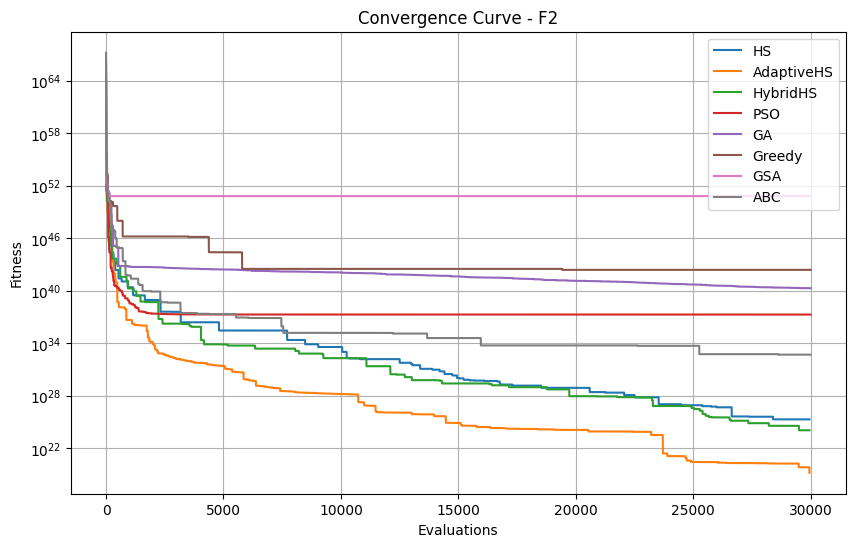

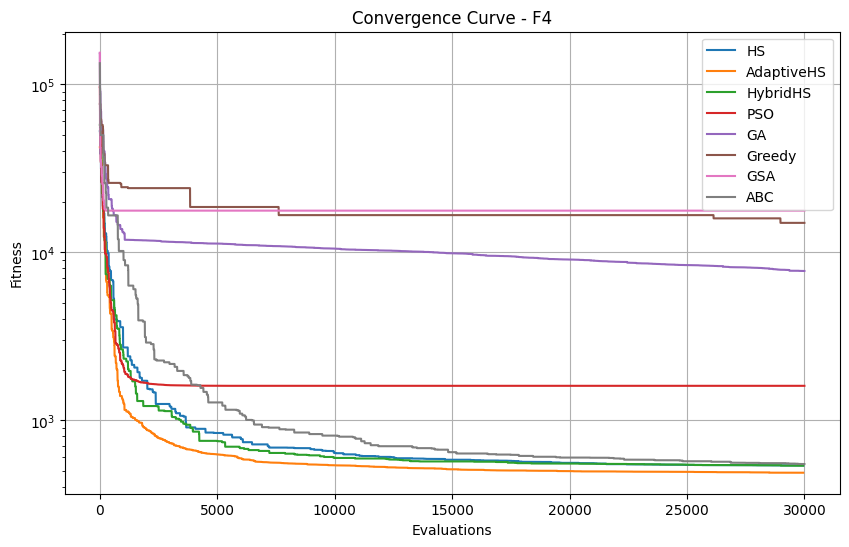

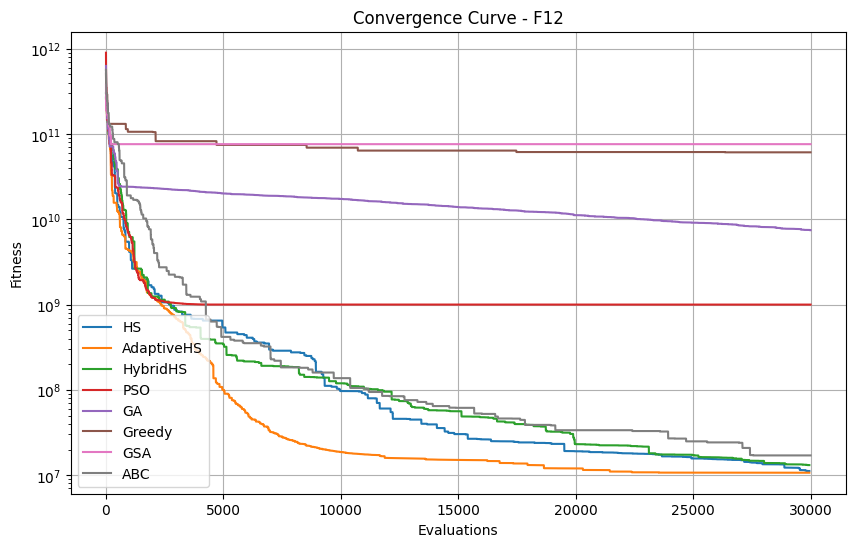

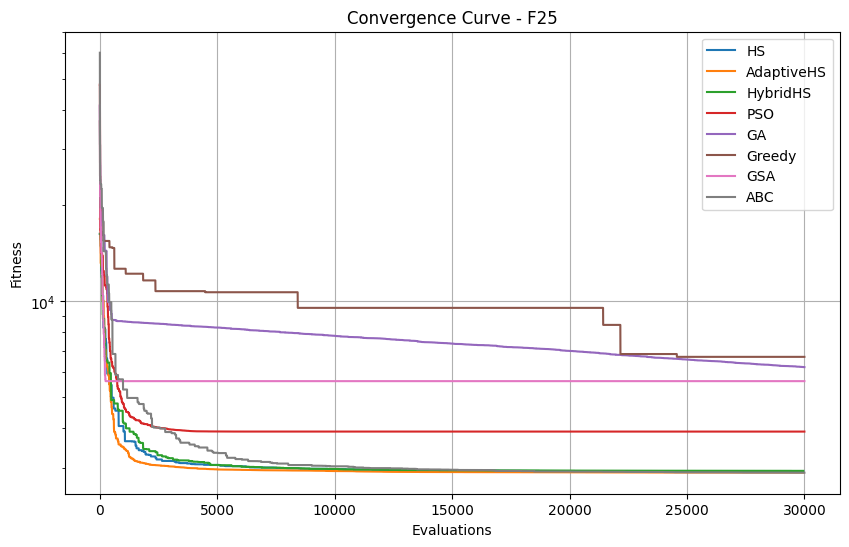

In [8]:
# Plot Convergence Curves
for func_name, algs in convergence_data.items():
    plt.figure(figsize=(10, 6))
    
    for alg_name, history in algs.items():
        plt.plot(history, label=alg_name)
        
    plt.title(f'Convergence Curve - {func_name}')
    plt.xlabel('Evaluations')
    plt.ylabel('Fitness')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()